In [1]:
#importamos las librerías necesarias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Cargamos la data

df = pd.read_csv('FMEL_Dataset.csv', delimiter=";")
len(df)

36305

In [3]:
#Renombramos las columnas del dataset

df.columns = ['id','season','division','round','local_team','visitor_team','local_goals','visitor_goals','date','timestamp']
df = df.drop(['id','timestamp'], axis=1)


In [4]:
df.head(5)

,season,division,round,local_team,visitor_team,local_goals,visitor_goals,date
0,1970-71,1,1,Athletic Club,Barcelona,1,1,12/09/1970
1,1970-71,1,1,Las Palmas,Atletico de Madrid,1,1,12/09/1970
2,1970-71,1,1,Real Madrid,Valencia,2,0,12/09/1970
3,1970-71,1,1,Celta de Vigo,Sporting de Gijon,2,0,13/09/1970
4,1970-71,1,1,Elche,Granada,1,1,13/09/1970


In [8]:
#Creamos la columna resultado

df['result'] = 'draw'
df.loc[df['local_goals'] > df['visitor_goals'], 'result'] = 'local'
df.loc[df['visitor_goals'] > df['local_goals'], 'result'] = 'visitor'

In [9]:
#Miramos los resultados de la columna resultado

df.groupby('result')['result'].count()

result
draw       10018
local      18385
visitor     7902
Name: result, dtype: int64

<Axes: ylabel='result'>

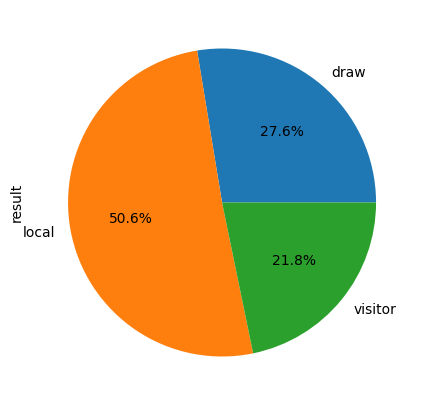

In [13]:
#Gráfico circular con los resultados

df.groupby('result')['result'].count().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))

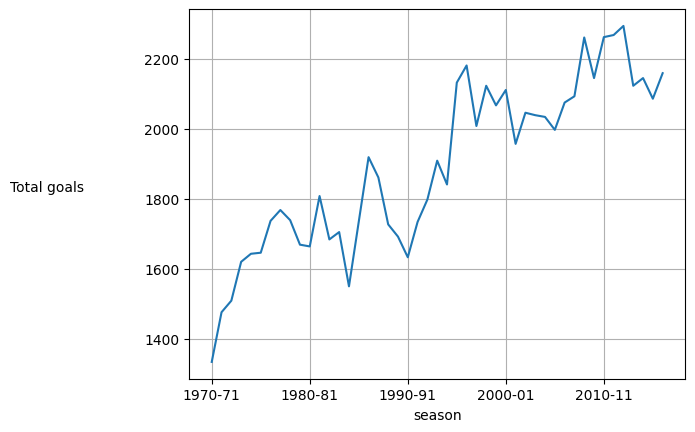

In [21]:
df['total_goals'] = df['visitor_goals'] + df['local_goals']

#Obtenemos un gráfico con el número total de goles marcados en todas las temporadas

df.groupby('season')['total_goals'].sum().plot()
plt.ylabel('Total goals', rotation=0, labelpad=70)
plt.grid(True)
plt.show()

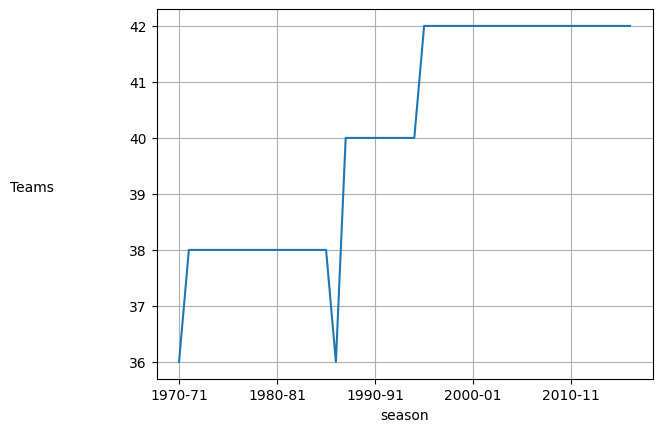

In [22]:
#Contamos el número de equipos que han estado en la primera división española y observamos que solo han habido 6 equipos nuevos
df.groupby('season')['local_team'].nunique().plot()
plt.ylabel('Teams', rotation=0, labelpad=70)
plt.grid(True)
plt.show()

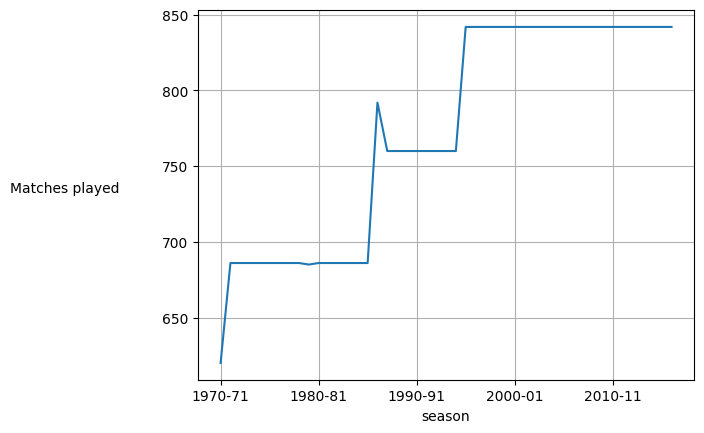

In [23]:
#Observamos el incremento de partidos a lo largo de las temporadas
df.groupby('season')['round'].count().plot()
plt.ylabel('Matches played', rotation=0, labelpad=70)
plt.grid(True)
plt.show()

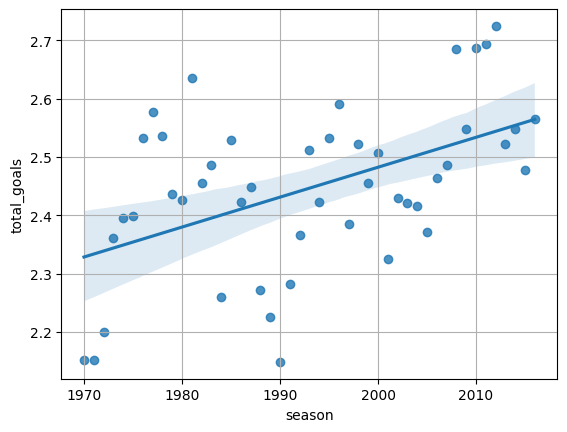

In [25]:
#Podemos observar como el número total de goles por temporada aumenta de manera lenta

avg_goals_per_season = df.groupby('season')['total_goals'].mean().reset_index()
avg_goals_per_season['season'] = avg_goals_per_season['season'].map(lambda s: int(s[:4]))
sns.regplot(x='season', y='total_goals', data=avg_goals_per_season)
plt.grid(True)

In [26]:
df['game_date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['game_month'] = df['game_date'].dt.month
df['game_weekday'] = df['game_date'].dt.weekday

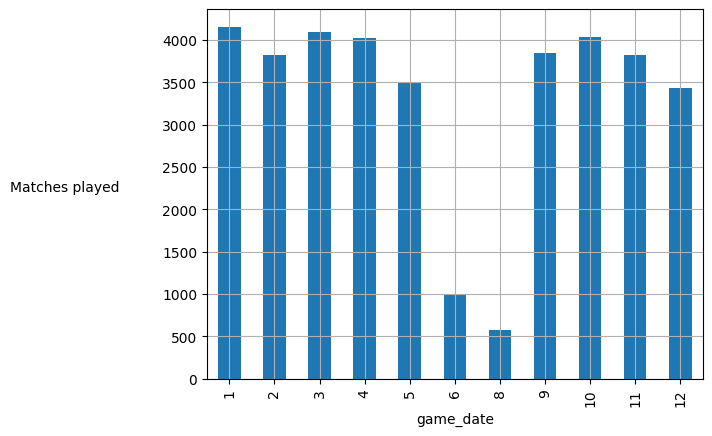

In [29]:
#Número de partidos por mes

df.groupby([df['game_date'].dt.month])['round'].count().plot(kind='bar')
plt.ylabel('Matches played', rotation=0, labelpad=70)
plt.grid(True)

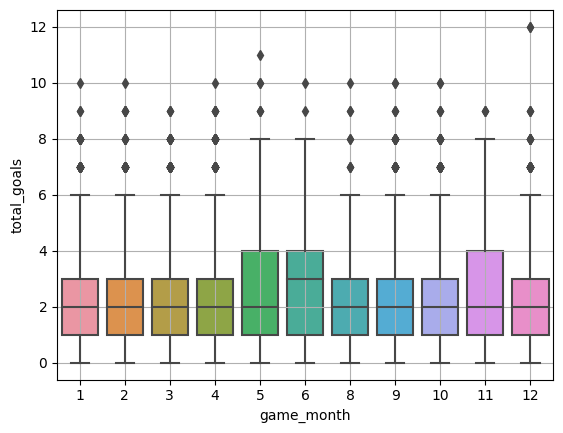

In [31]:
sns.boxplot(x='game_month', y='total_goals', data=df)
plt.grid(True)

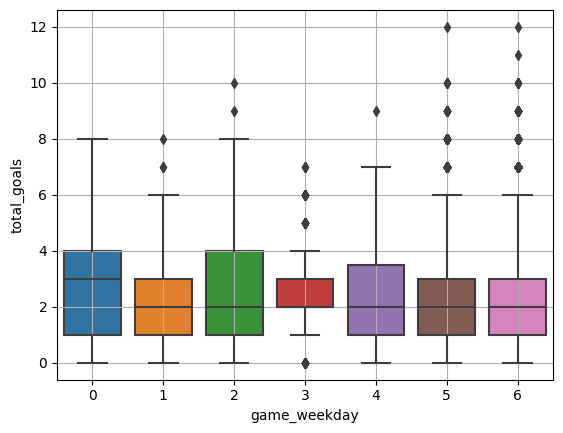

In [32]:
#Observamos como se marcan más goles los lunes

sns.boxplot(x='game_weekday', y='total_goals', data=df)
plt.grid(True)

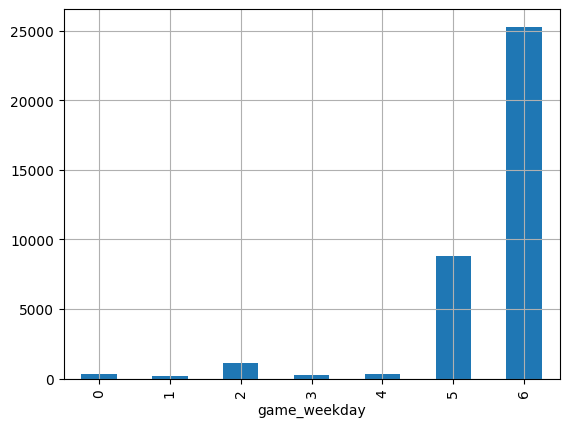

In [33]:
#El mayor número de partidos se juegan los fines de semana 

df.groupby('game_weekday')['round'].count().plot(kind='bar')
plt.grid(True)

In [34]:
#Convertir la columna de resultado a tres columnas binarias para poder sumarlas posteriormente.

df = df.merge(pd.get_dummies(df['result']), left_index=True, right_index=True)

In [35]:
#Añadimos como nuevas columnas la cantidad de victorias locales y visitantes por temporada.

df['local_wins_this_season'] = df.groupby(['season','local_team'])['local'].transform('sum')
df['visitor_wins_this_season'] = df.groupby(['season','visitor_team'])['visitor'].transform('sum')

In [37]:
#Mostramos los equipos que mas partidos ganan como locales de media por temporada.
(df.groupby(['local_team'])['local_wins_this_season'].agg(['count','mean']).sort_values(ascending=False, by='mean')
    .round(1).head(10))

,count,mean
local_team,,
Real Madrid,866,14.2
Barcelona,866,14.0
Sant Andreu,133,12.3
Barakaldo,114,11.7
Atletico de Madrid,870,11.6
Alcorcon,147,11.3
Valencia,866,11.1
AD Ceuta,19,11.0
Sevilla,878,10.9


In [39]:
#Mostramos los equipos que mas partidos ganan como visitantes de media por temporada.

(df.groupby(['visitor_team'])['visitor_wins_this_season'].agg(['count','mean']).sort_values(ascending=False, by='mean')
    .round(1).head(10))

,count,mean
visitor_team,,
Real Madrid,866,8.4
Barcelona,866,8.0
Burgos CF,21,8.0
Villarreal B,63,6.3
Atletico de Madrid,870,6.0
Girona,189,6.0
Mallorca B,21,6.0
Reus,21,6.0
Alicante,21,6.0


In [41]:
#Total de victorias por temporada

visitor_results = (df.groupby(['season', 'visitor_team'])['visitor'].sum().reset_index().rename(columns={'visitor_team': 'team',
                                    'visitor': 'visitor_wins'}))

local_results = (df.groupby(['season', 'local_team'])['local'].sum().reset_index().rename(columns={'local_team': 'team',
                                  'local': 'local_wins'}))

wins_per_season = visitor_results.merge(local_results, on=['season', 'team'])

wins_per_season['total_wins'] = wins_per_season['visitor_wins'] + wins_per_season['local_wins']

wins_per_season.head(5)

,season,team,visitor_wins,local_wins,total_wins
0,1970-71,Athletic Club,3,11,14
1,1970-71,Atletico de Madrid,4,13,17
2,1970-71,Barcelona,8,11,19
3,1970-71,Betis,5,15,20
4,1970-71,Burgos,3,16,19


In [42]:
total_wins_sorted_desc = (wins_per_season.groupby(['team'])['total_wins'].sum().sort_values(ascending=False).reset_index()['team'])

wins_per_season_pivot = (wins_per_season.pivot_table(index='team',columns='season',values='total_wins').fillna(0).reindex(total_wins_sorted_desc))

<Axes: xlabel='season', ylabel='team'>

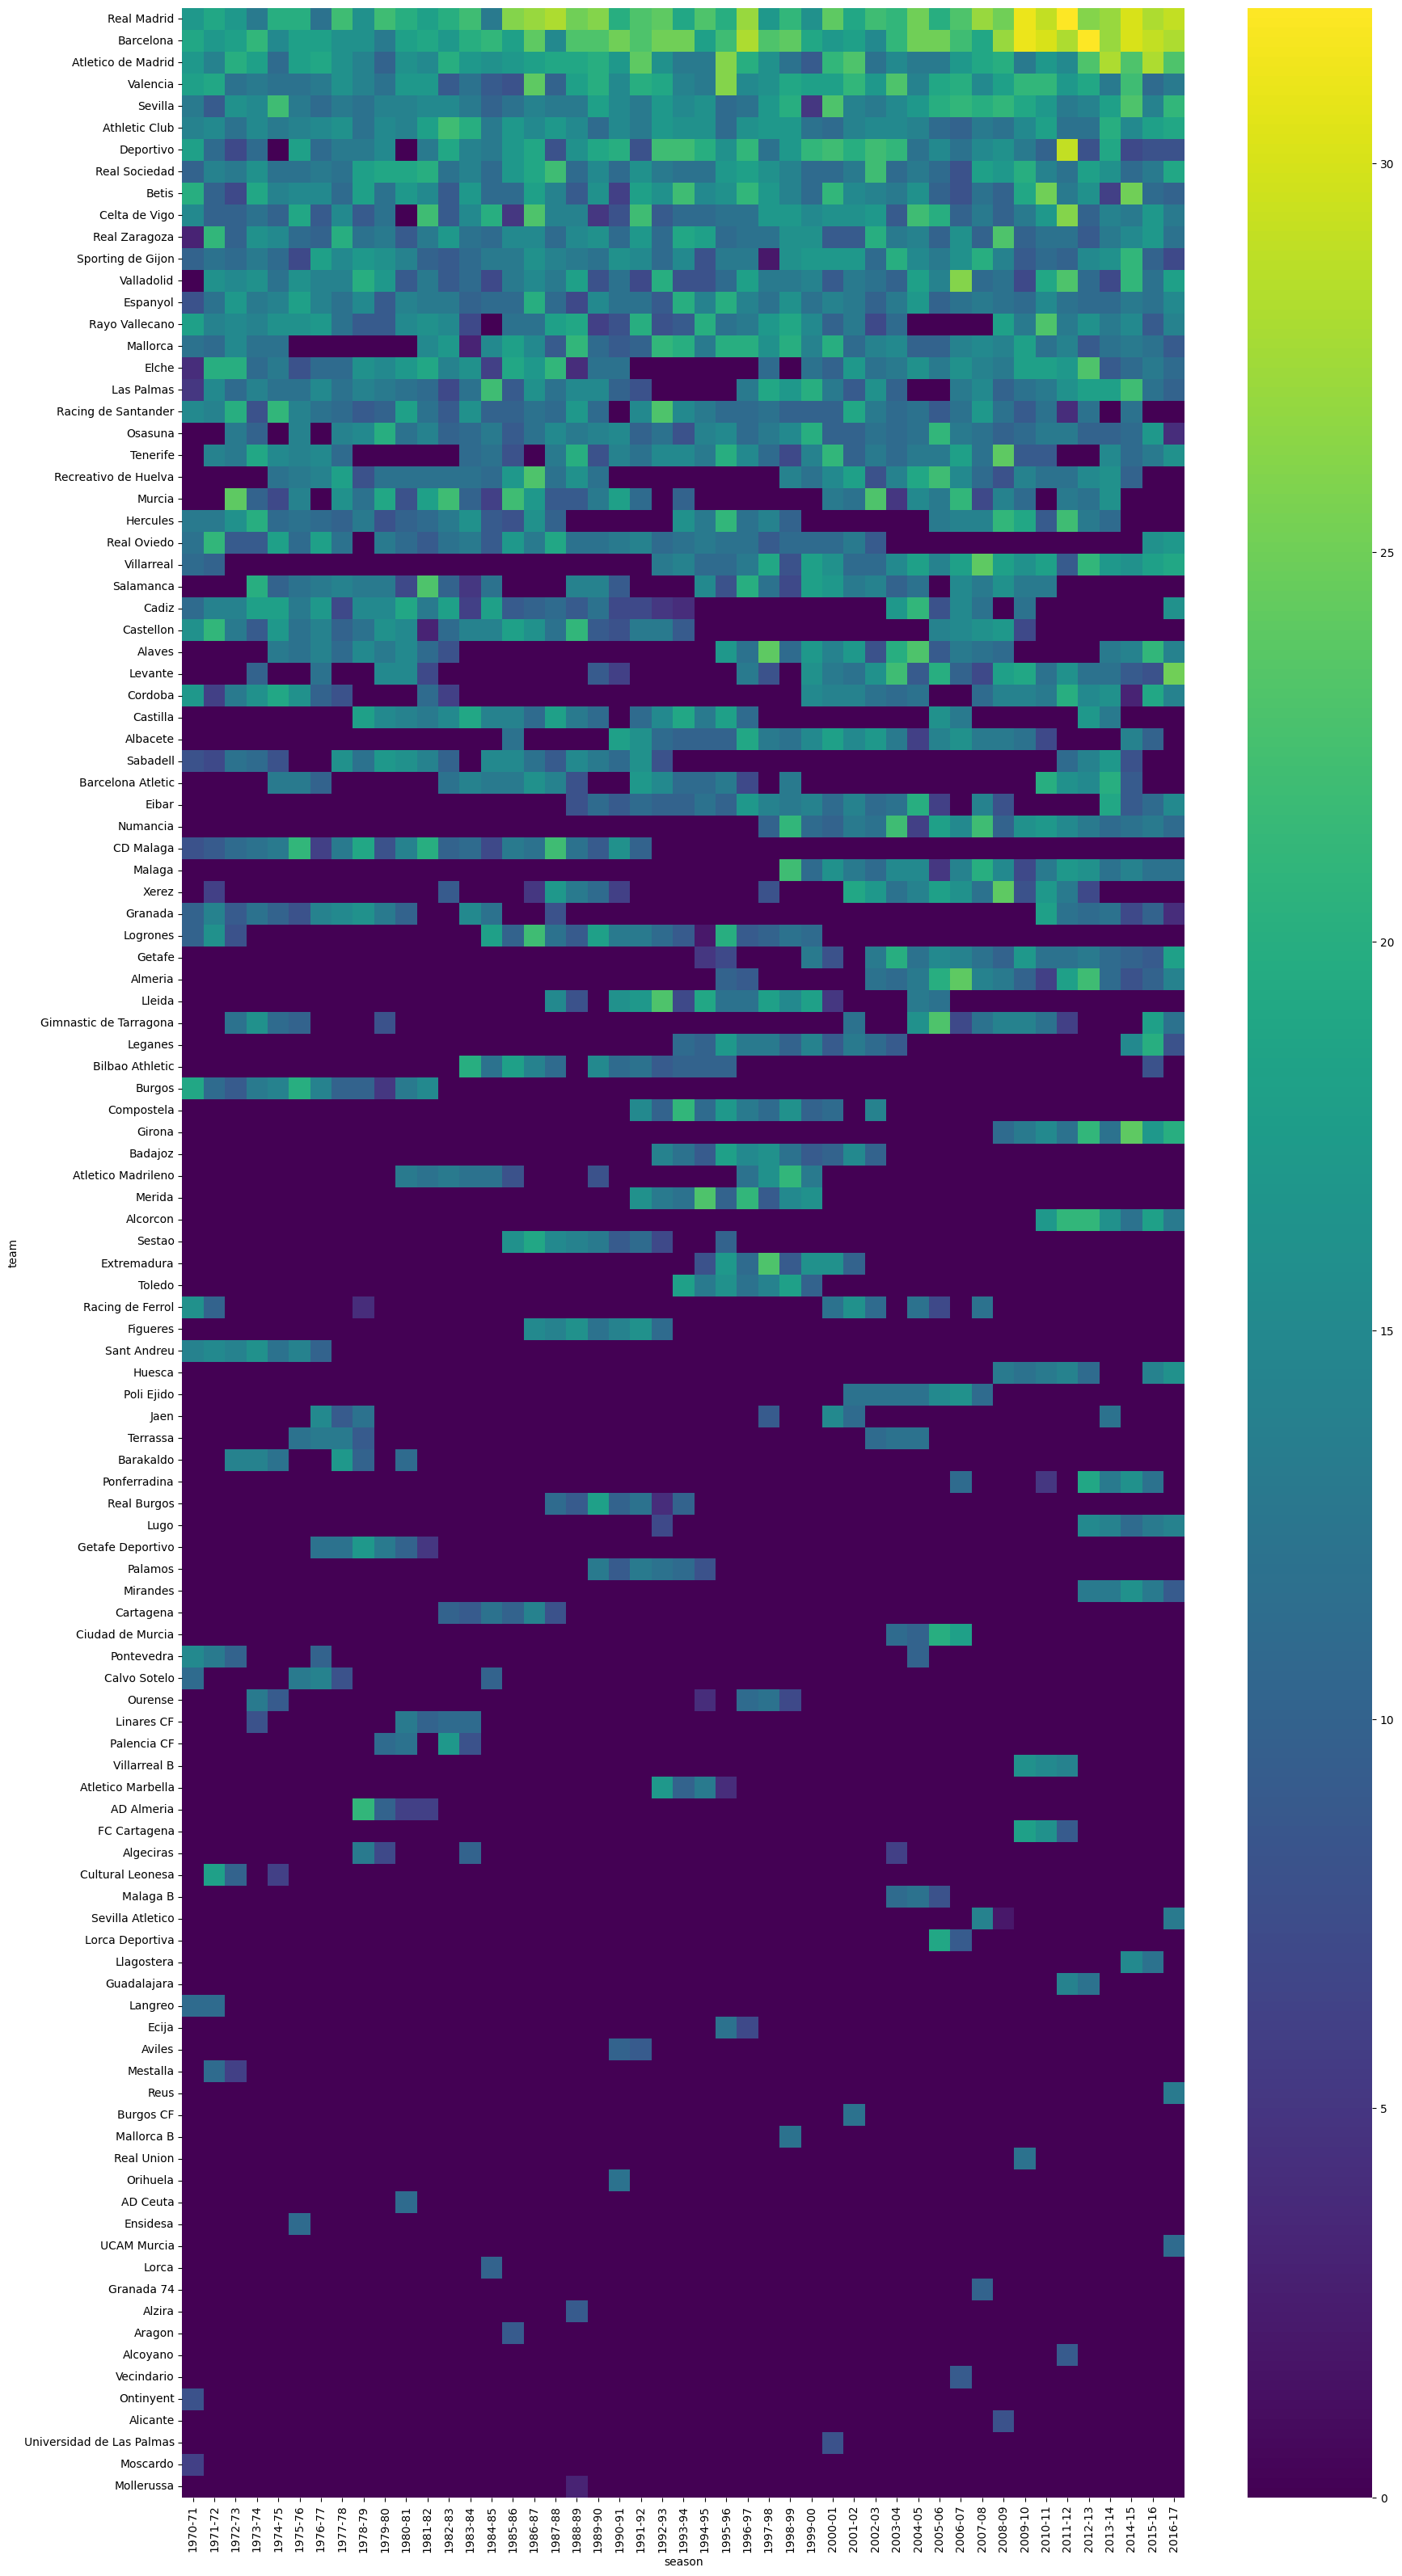

In [45]:
#Observar el total de victorias por temporada a lo largo del tiempo

plt.figure(figsize=(20, 40))
sns.heatmap(wins_per_season_pivot, cmap='viridis')

C:\Users\angel\AppData\Local\Temp\ipykernel_24168\123350230.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wps = wps.groupby(['team'])['total_wins','local_wins','visitor_wins'].sum().reset_index()


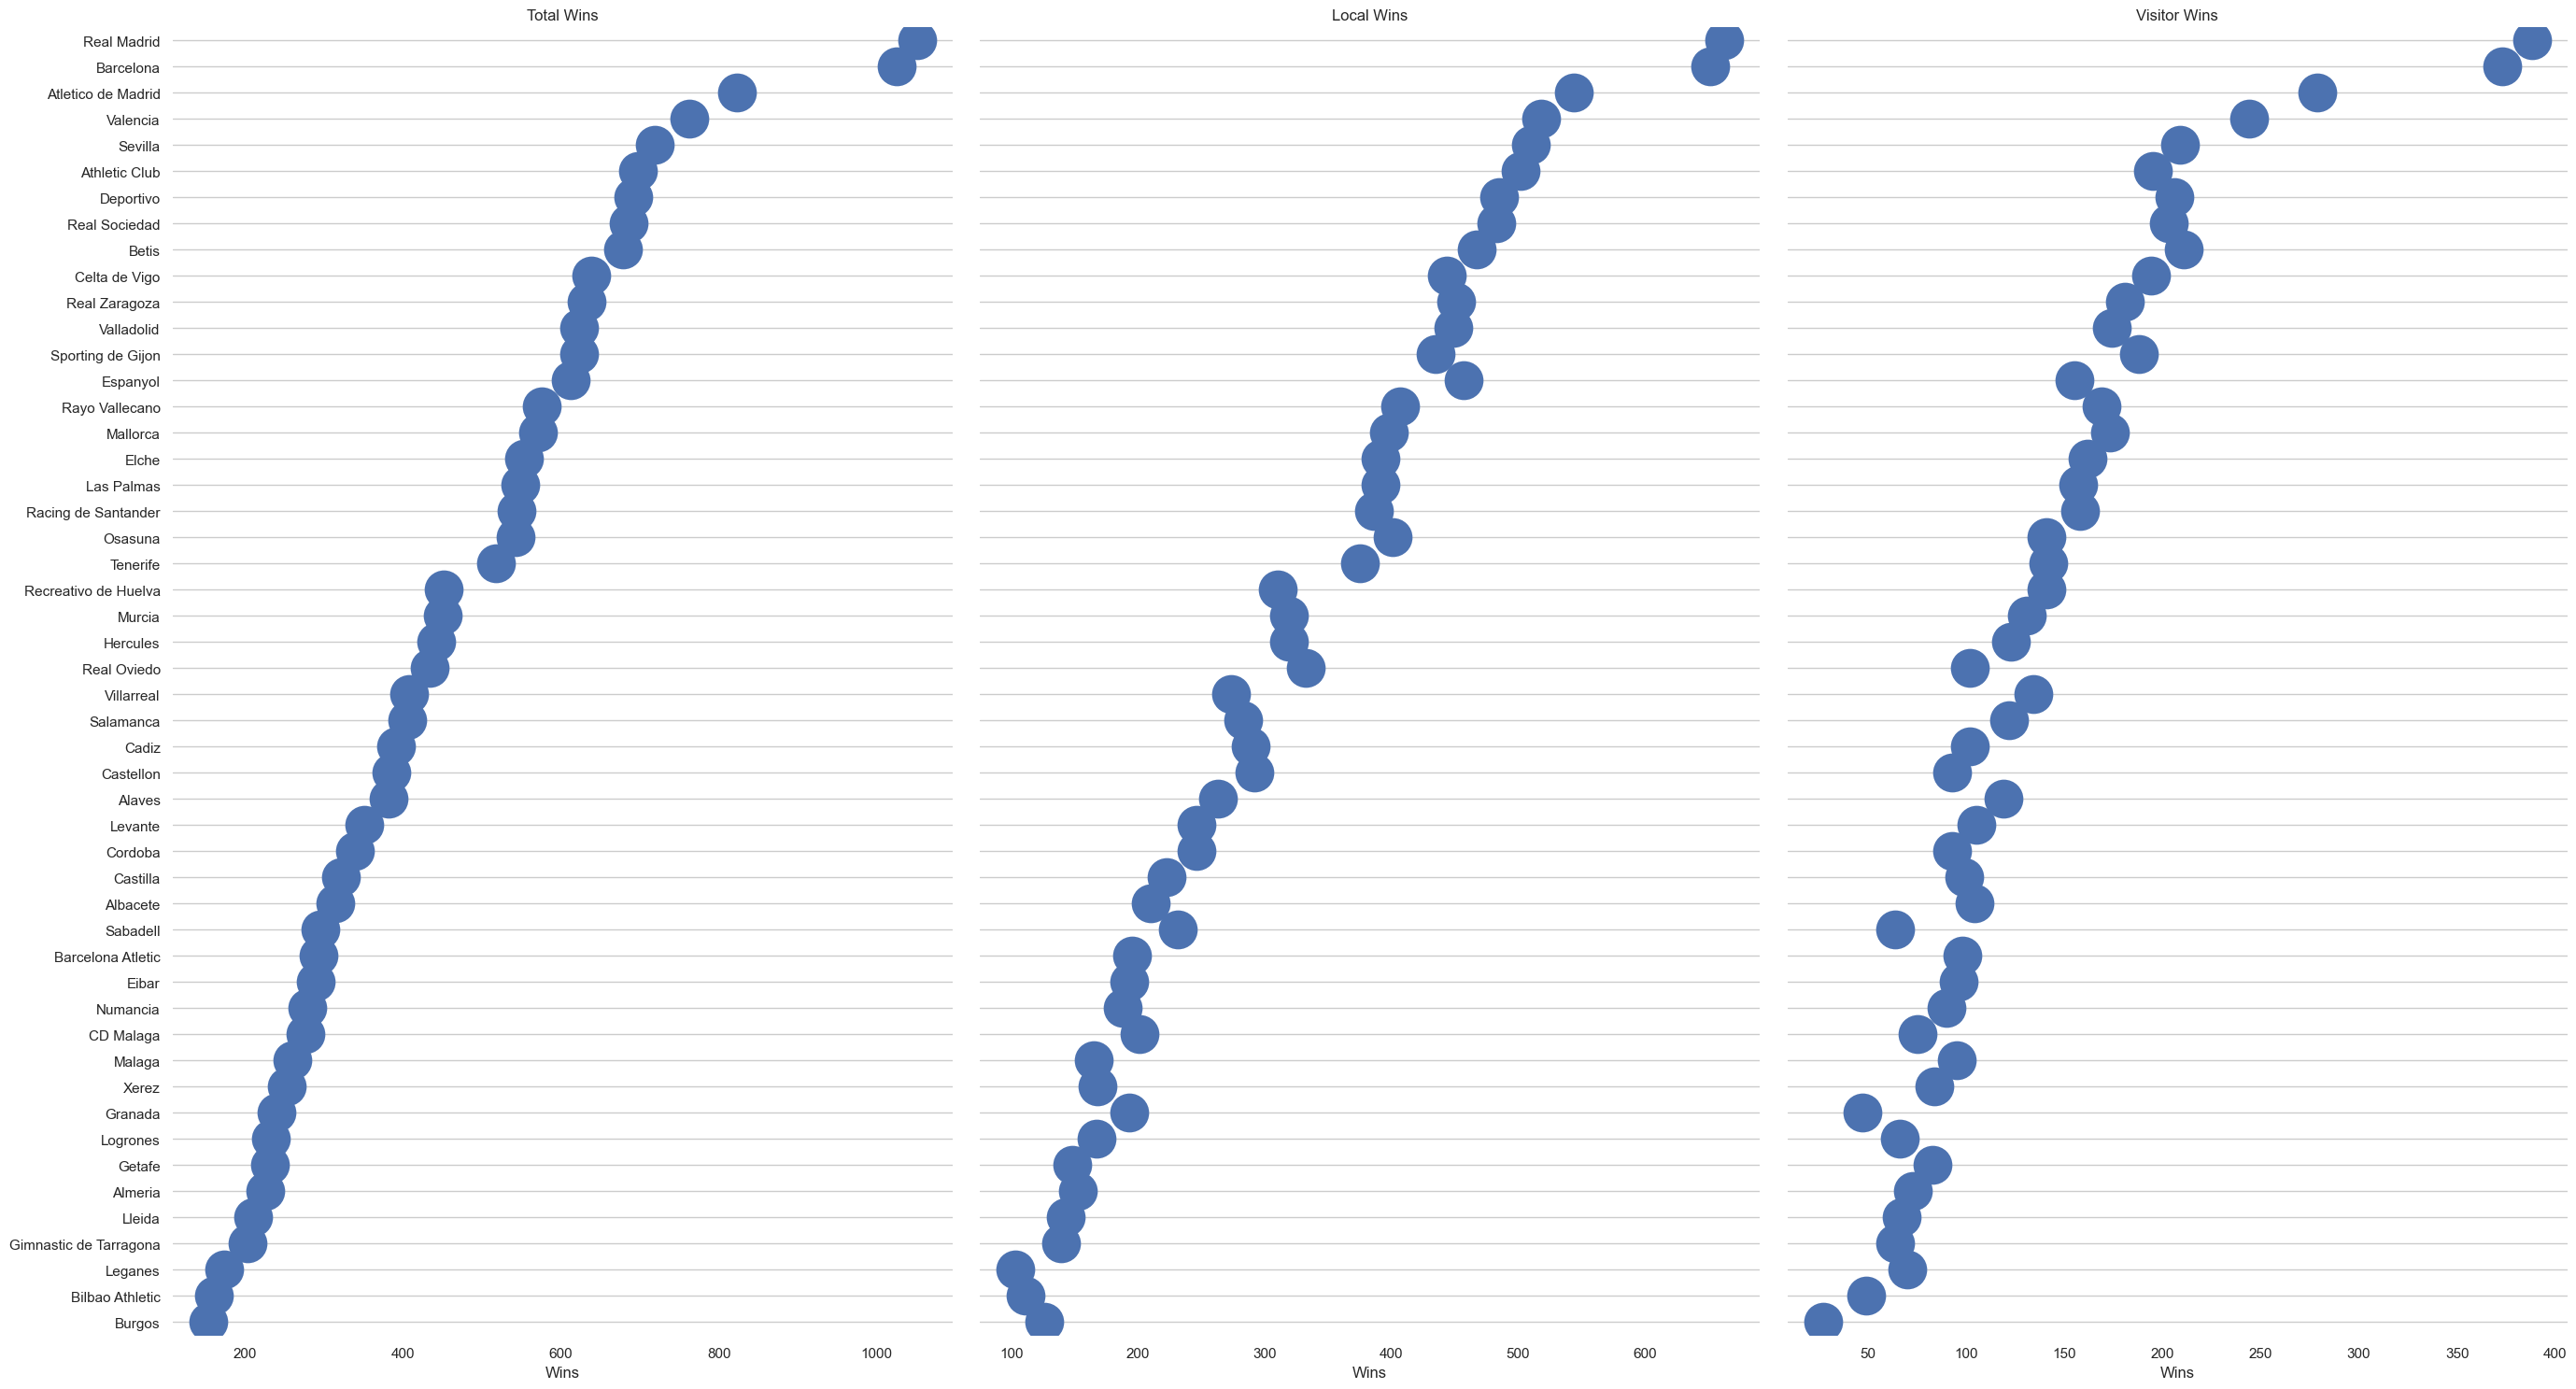

In [50]:
#Observar que victorias contribuyeron al total de victorias

sns.set(style="whitegrid")

#Reorganizar los datos

top_50 = wins_per_season[wins_per_season['team'].isin(total_wins_sorted_desc[:50])]
wps = top_50[['team','total_wins','local_wins','visitor_wins']]
wps = wps.groupby(['team'])['total_wins','local_wins','visitor_wins'].sum().reset_index()

#Hacer el pairgrid

g = sns.PairGrid(wps.sort_values("total_wins", ascending=False),
                 x_vars=wps.columns[1:], y_vars=["team"],
                 height=15, aspect=.6)

#Dibujar un gráfico de puntos con la función stripplot

g.map(sns.stripplot, size=30, orient="h",
      palette="Reds_r", edgecolor="gray")

#Utilizar los mismos límites del eje x en todas las columnas y añadir mejores etiquetas.

g.set(xlabel="Wins", ylabel="")

#Utilizar títulos para las columnas

titles = ["Total Wins", "Local Wins", "Visitor Wins"]

for ax, title in zip(g.axes.flat, titles):

    # Establecer un título diferente para cada eje
    ax.set(title=title)

    # Hacer la cuadrícula horizontal en lugar de vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

C:\Users\angel\AppData\Local\Temp\ipykernel_24168\68391037.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  wps = wps.groupby(['team'])['total_wins','local_wins','visitor_wins'].sum().reset_index()


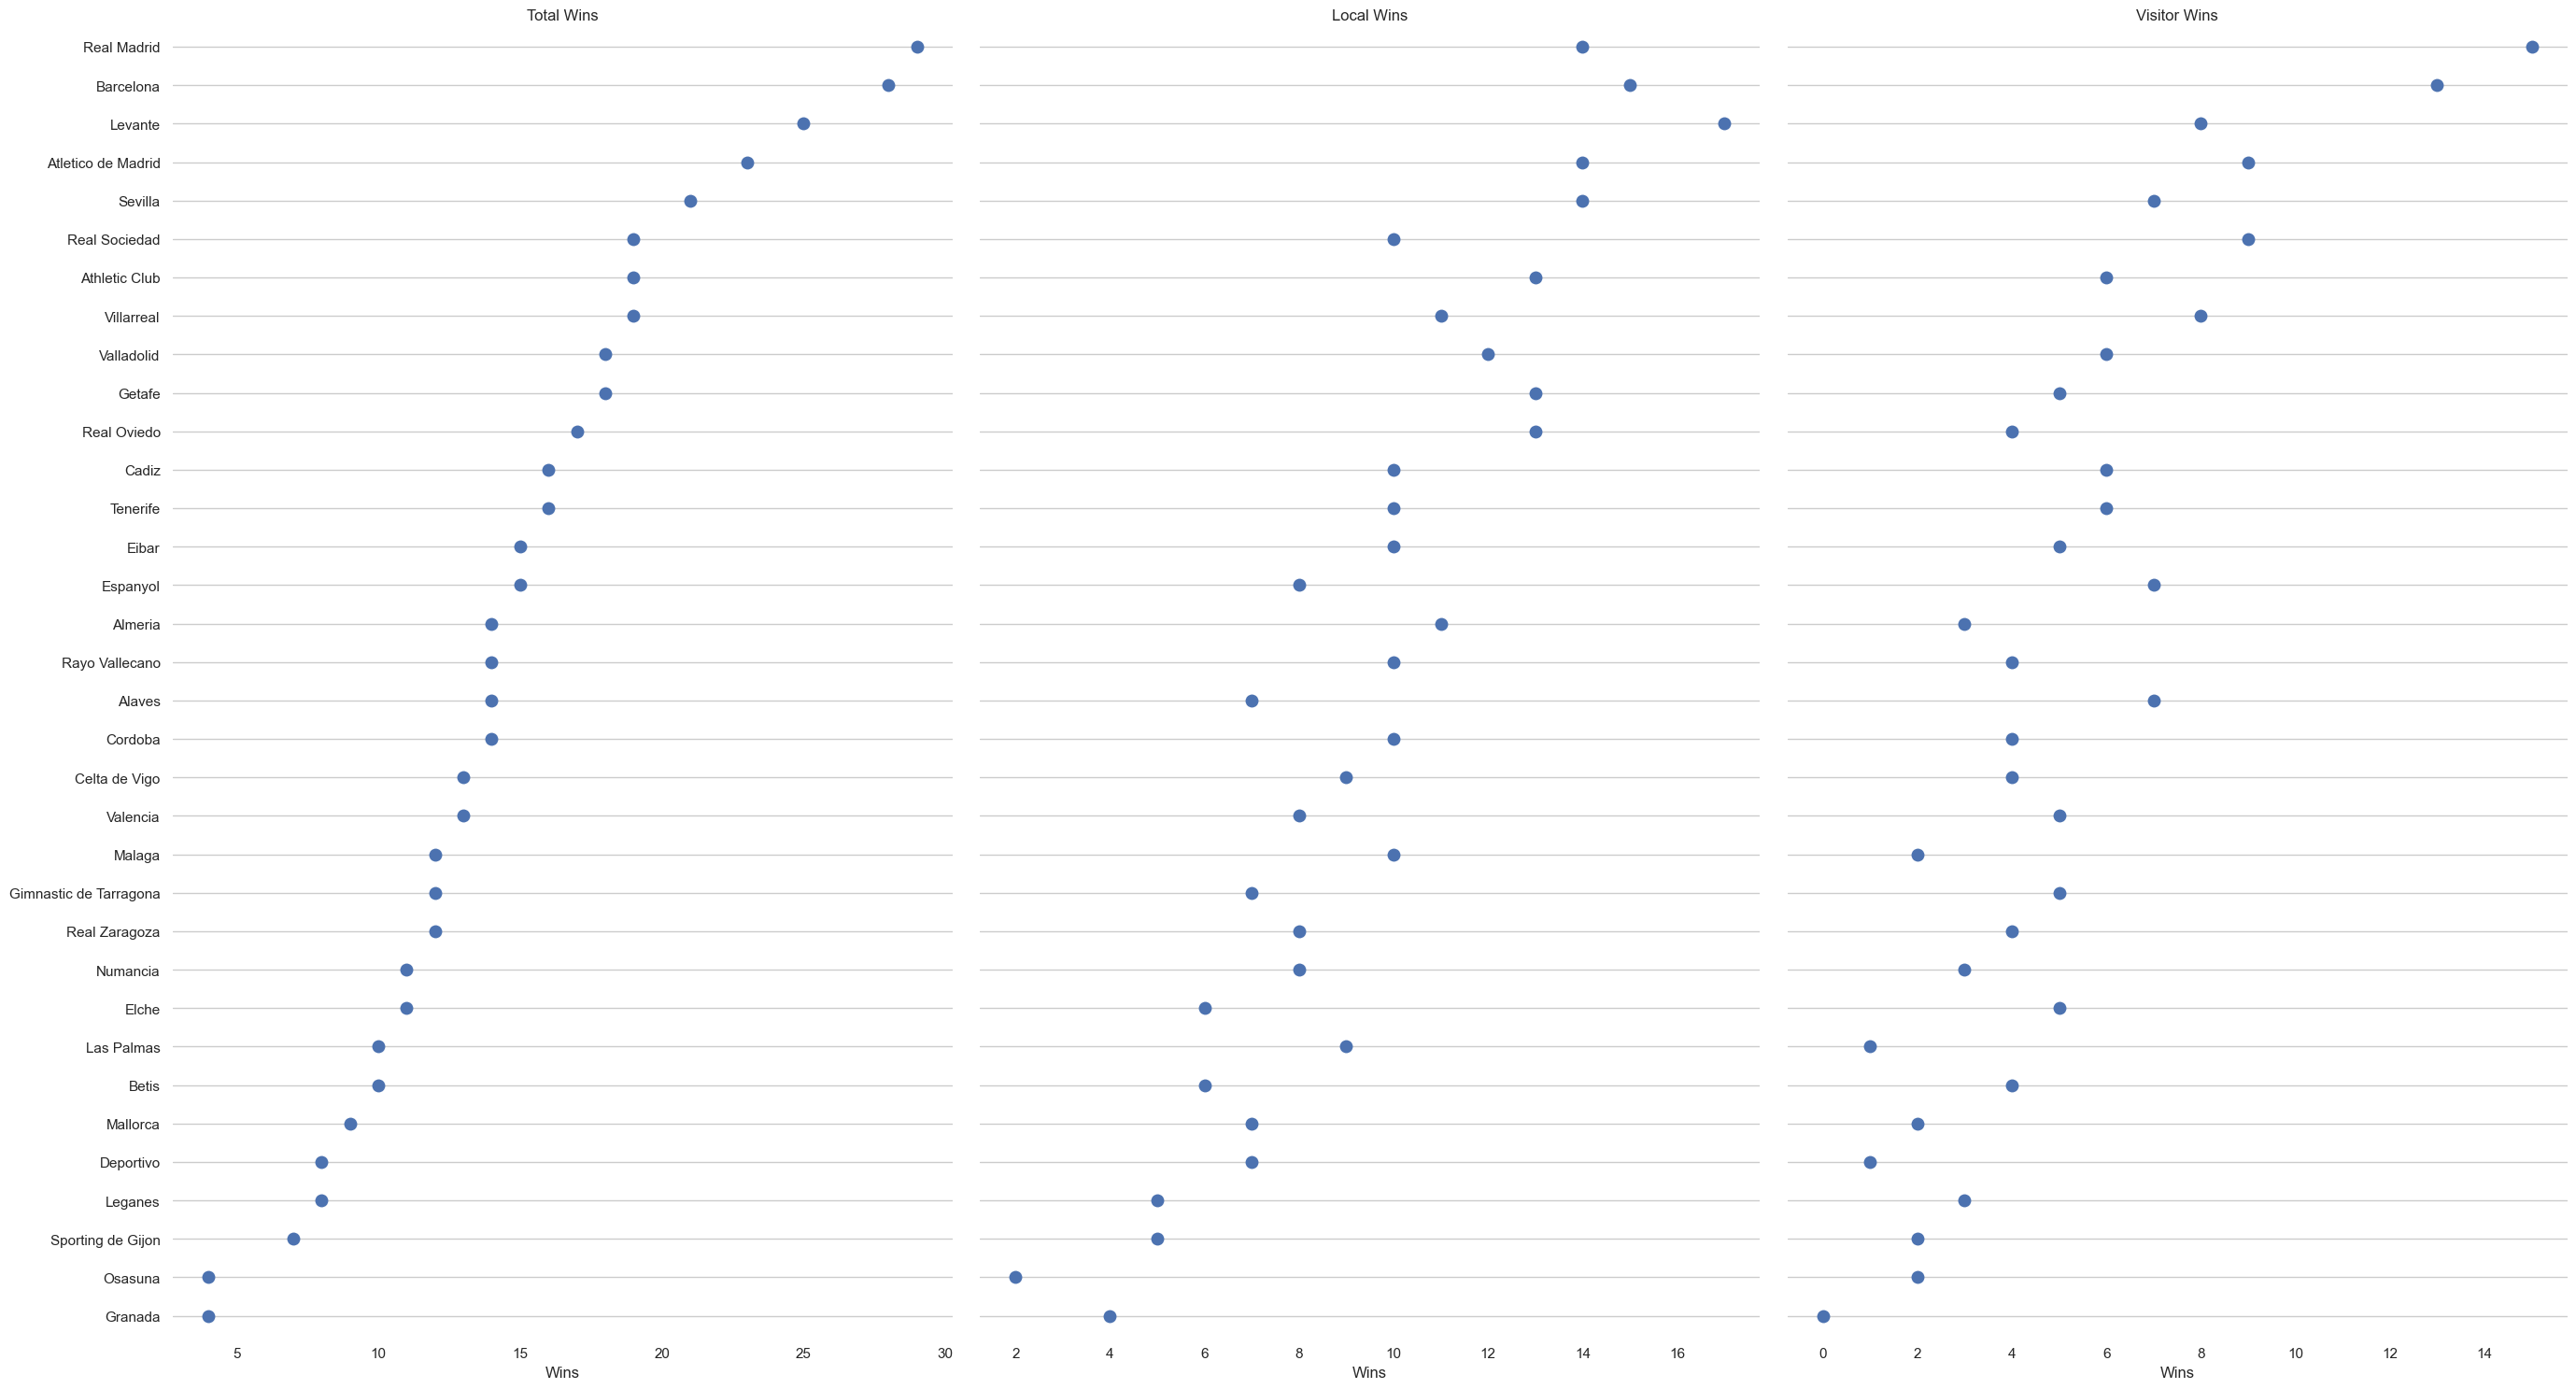

In [51]:
#Repetimos lo anterior pero para los últimos 5 años
sns.set(style="whitegrid")


top_50 = wins_per_season[(wins_per_season['team'].isin(total_wins_sorted_desc[:50]))
                         &
                         (wins_per_season['season'].isin(df['season'].sort_values(ascending=False)[:5]))]
wps = top_50[['team','total_wins','local_wins','visitor_wins']]
wps = wps.groupby(['team'])['total_wins','local_wins','visitor_wins'].sum().reset_index()


g = sns.PairGrid(wps.sort_values("total_wins", ascending=False),
                 x_vars=wps.columns[1:], y_vars=["team"],
                 height=15, aspect=.6)


g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")


g.set(xlabel="Wins", ylabel="")


titles = ["Total Wins", "Local Wins", "Visitor Wins"]

for ax, title in zip(g.axes.flat, titles):

    
    ax.set(title=title)

    
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

<Axes: xlabel='wins', ylabel='value'>

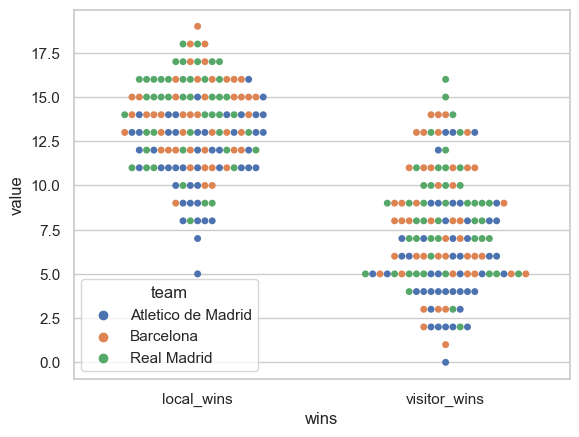

In [52]:
#Observamos las victorias por temporada para el top 3 de equipos, cada punto es una temporada 

top3 = wins_per_season[wins_per_season['team'].isin(['Real Madrid', 'Barcelona', 'Atletico de Madrid'])]
melt = pd.melt(top3[['team','local_wins','visitor_wins']], 'team', var_name='wins')
sns.swarmplot(x="wins", y="value", hue="team", data=melt)